In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

import xgboost as xgb
import keras

from ucimlrepo import fetch_ucirepo

from IPython.display import clear_output
import os
import logging
import re
import warnings

import utils

logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

clear_output()

std_plot_size = (6.4, 4.8)
start_seed = 82

plots_dir = os.path.join('plots', 'part_b')
tables_dir = os.path.join('tables', 'part_b')

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
    
if not os.path.exists(tables_dir):
    os.makedirs(tables_dir)
    
sns.set_palette('hls')

minimal_run = True

mlp_runs = 30 if not minimal_run else 2
mlp_tuning_runs = 10 if not minimal_run else 2
rf_tuning_runs = 10 #if not minimal_run else 2

rf_runs = 30 #if not minimal_run else 2
rf_estimators = [1, 3, 5, 6, 9] + [2 ** x * 10 for x in range(1, 8)] #if not minimal_run else [1, 3]

mlp_params = {
    'hidden_layer_sizes': [(20,), (40,)], #, (20, 20), (20, 40, 20),],
    'activation': ['relu', 'logistic'],
    'alpha': [0.0001, 0.001],# 0.01],
    'beta_1': [0.85, 0.9],# 0.95],
}

logging.info('Start Execution')

INFO - 2024-11-15 00:17:32,196 - Start Execution


In [2]:
# Retrieve dataset
dataset = fetch_ucirepo(id=30)

# Merge target into dataframe for easy comparisons
df = pd.concat([dataset.data.features.copy(), dataset.data.targets.copy()], axis=1)

Switched Wife Working + Media Exposure to Make more sense
Adjusted contraceptive method param 

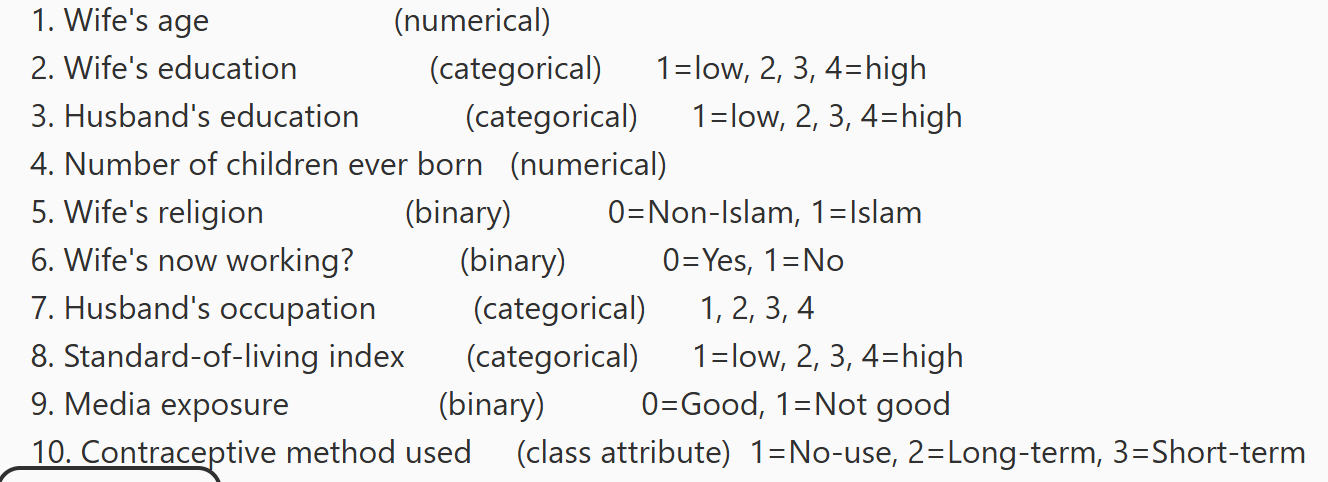

In [3]:
# Perform Cleaning
transformed_df = df.copy()

# TODO: consider changing ratios
transformed_df['adjusted_method'] = np.where(df['contraceptive_method'].eq(2), 5, df['contraceptive_method'])

# Reverse so that 1/true/positive are aligned
transformed_df['wife_working'] = df['wife_working'].eq(0).astype(int)
transformed_df['media_exposure'] = df['media_exposure'].eq(0).astype(int)

transformed_df = transformed_df.drop(columns='contraceptive_method')

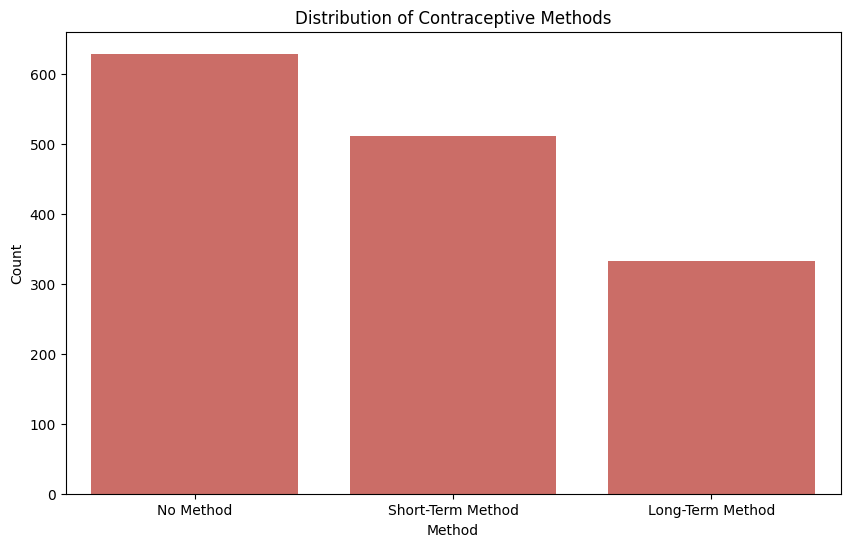

In [4]:
contra_methods = ['No Method', 'Short-Term Method', 'Long-Term Method']

method_labels = pd.DataFrame(np.select(
    [df['contraceptive_method'].eq(3), df['contraceptive_method'].eq(2)],
    contra_methods[1:],
    default=contra_methods[0]
), columns = ['Contraception Method'])

plt.figure(figsize=(10, 6))
sns.countplot(x='Contraception Method', data=method_labels, order=contra_methods)
plt.title('Distribution of Contraceptive Methods')
plt.xlabel('Method')
plt.ylabel('Count')
plt.savefig(os.path.join(plots_dir, 'class_distribution.png'))
plt.show()

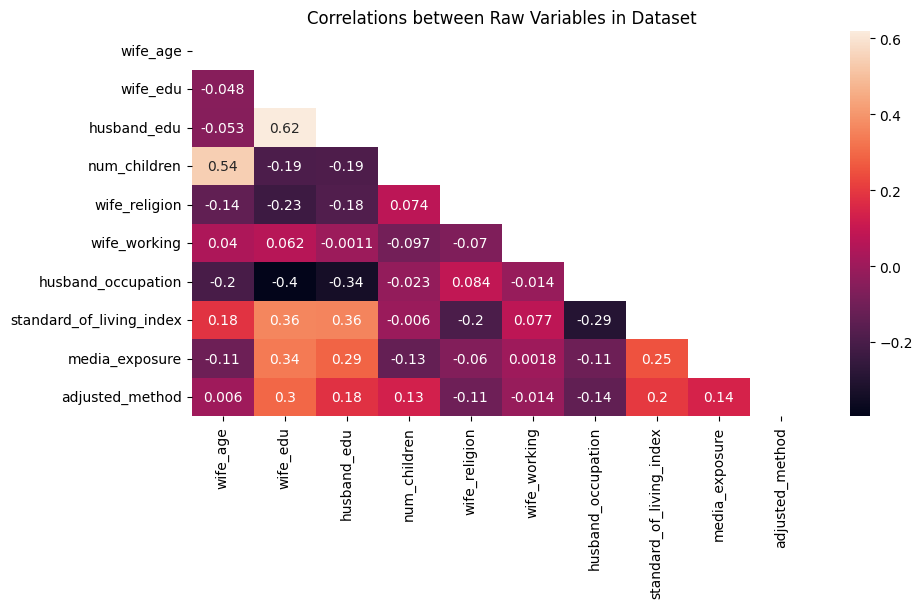

In [5]:
plt.figure(figsize=(10, 5))
plt.title('Correlations between Raw Variables in Dataset')

corr_df = transformed_df.corr()
# Create a mask of only the upper triangle, to simplify the heatmap
matrix = np.triu(corr_df)
sns.heatmap(corr_df, annot=True, mask=matrix)
plt.savefig(os.path.join(plots_dir, 'heat_map.png'), bbox_inches = 'tight')

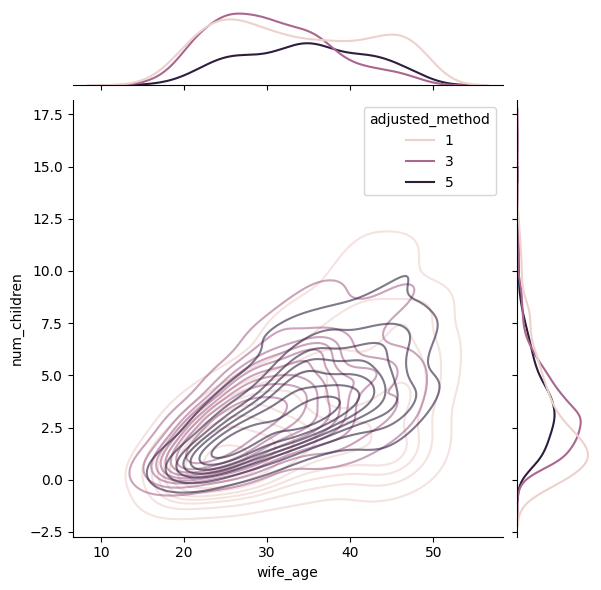

In [6]:
sns.jointplot(data=transformed_df, x="wife_age", y="num_children", hue="adjusted_method", kind="kde", alpha=0.6)
plt.savefig(os.path.join(plots_dir, 'num_child_vs_wife_age.png'))

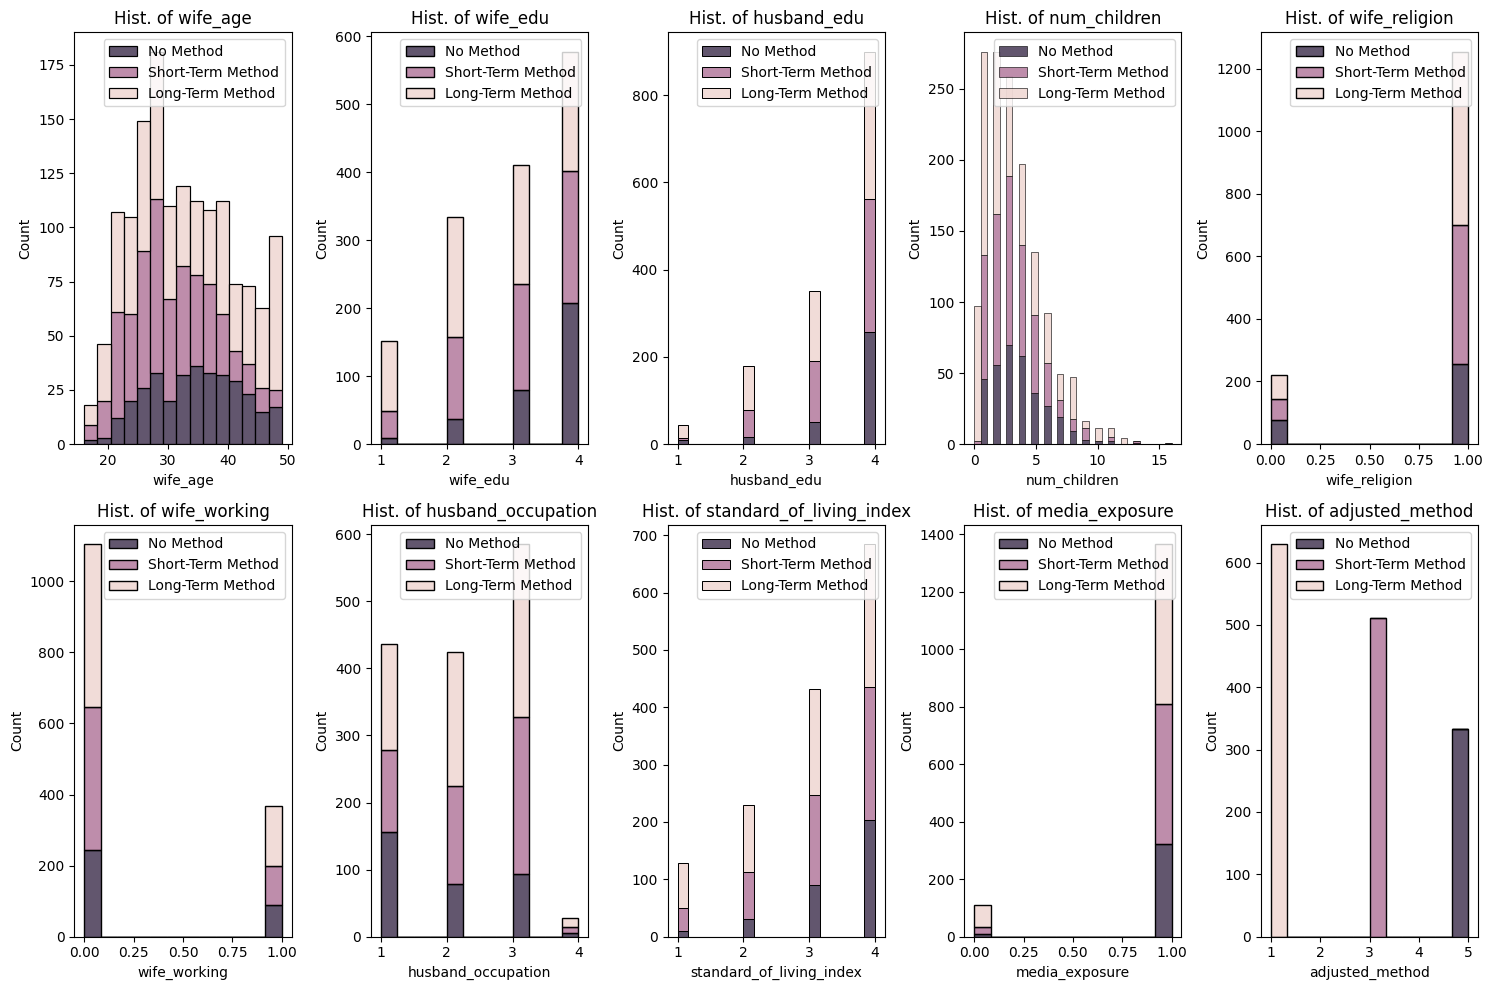

In [7]:
plt.figure(figsize=(15, 10))
for ii, feature in enumerate(transformed_df.columns, start=1):
    plt.subplot(2, 5, ii)
    sns.histplot(data=transformed_df, x=feature, hue='adjusted_method', multiple='stack')
    plt.title(f'Hist. of {feature}')
    plt.legend(title='', loc='upper right', labels=contra_methods)
    
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'feature_distributions.png'))
plt.show()

In [8]:
feature_df = transformed_df.drop(['adjusted_method'], axis=1)
target = transformed_df['adjusted_method']
model_accuracy = {}

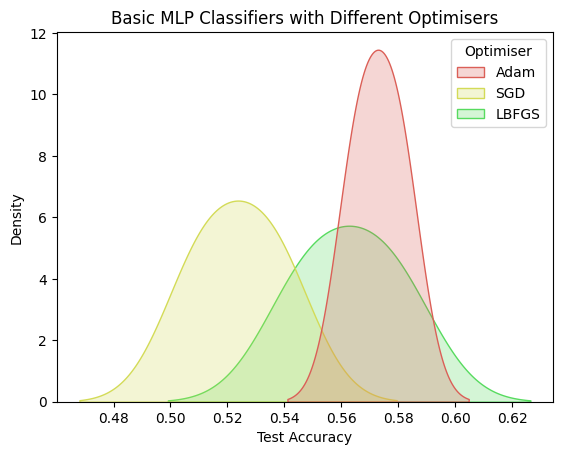

In [ ]:
mlp_adam_df = utils.classifier_test(feature_df, target, MLPClassifier, {'solver': 'adam'},
                        [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                        )

mlp_adam_df['Optimiser'] = 'Adam'

mlp_sgd_df = utils.classifier_test(feature_df, target, MLPClassifier, {'solver': 'sgd'},
                        [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                        )
mlp_sgd_df['Optimiser'] = 'SGD'

mlp_lbfgs_df = utils.classifier_test(feature_df, target, MLPClassifier, {'solver': 'lbfgs'},
                        [10000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                        )
mlp_lbfgs_df['Optimiser'] = 'LBFGS'

sns.kdeplot(data=pd.concat([mlp_adam_df, mlp_sgd_df, mlp_lbfgs_df]), x='Test Accuracy', hue='Optimiser', fill=True)
plt.title('Basic MLP Classifiers with Different Optimisers')
plt.savefig(os.path.join(plots_dir, 'optimiser_comparison.png'))

model_accuracy['mlp_base_adam'] = round(float(mlp_adam_df['Test Accuracy'].mean().max()), 3)
# model_accuracy['mlp_sgd'] = float(mlp_sgd_df['Test Accuracy'].mean().max().round(3))

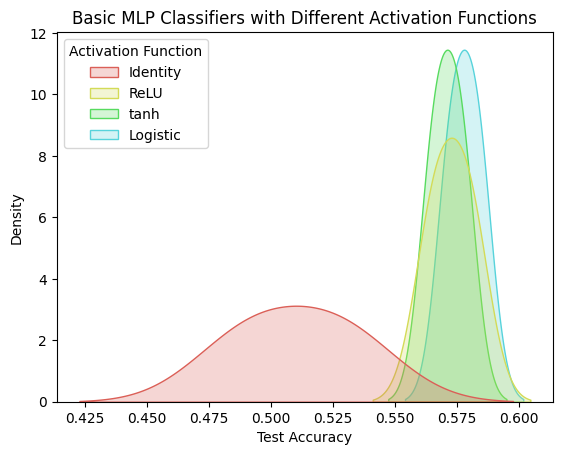

In [10]:
mlp_iden_df = utils.classifier_test(feature_df, target, MLPClassifier, {'activation': 'identity'},
                        [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                        )

mlp_iden_df['Activation Function'] = 'Identity'

mlp_relu_df = utils.classifier_test(feature_df, target, MLPClassifier, {'activation': 'relu'},
                        [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                        )
mlp_relu_df['Activation Function'] = 'ReLU'

mlp_tanh_df = utils.classifier_test(feature_df, target, MLPClassifier, {'activation': 'tanh'},
                        [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                        )
mlp_tanh_df['Activation Function'] = 'tanh'

mlp_log_df = utils.classifier_test(feature_df, target, MLPClassifier, {'activation': 'logistic'},
                        [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                        )
mlp_log_df['Activation Function'] = 'Logistic'

sns.kdeplot(data=pd.concat([mlp_iden_df, mlp_relu_df, mlp_tanh_df, mlp_log_df]), x='Test Accuracy', hue='Activation Function', fill=True)
plt.title('Basic MLP Classifiers with Different Activation Functions')
plt.savefig(os.path.join(plots_dir, 'activation_fn_comparison.png'))

# model_accuracy['mlp_adam'] = float(mlp_adam_df['Test Accuracy'].mean().max().round(3))
# model_accuracy['mlp_sgd'] = float(mlp_sgd_df['Test Accuracy'].mean().max().round(3))

In [ ]:
mlp_classifier = MLPClassifier(max_iter=10000, solver='adam', random_state=start_seed)


mlp_grid_search = GridSearchCV(mlp_classifier, mlp_params, cv=mlp_tuning_runs, verbose=1)
mlp_grid_search.fit(feature_df, target)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=MLPClassifier(max_iter=10000, random_state=82),
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.0001, 0.001], 'beta_1': [0.85, 0.9],
                         'hidden_layer_sizes': [(20,), (40,)]},
             verbose=1)

In [ ]:
raw_mlp_cv_results_df = pd.DataFrame(mlp_grid_search.cv_results_)
drop_cols = ['std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'std_test_score', 'mean_fit_time'] + [col for col in raw_mlp_cv_results_df.columns if 'split' in col]
mlp_cv_results_df = raw_mlp_cv_results_df.drop(columns=drop_cols)
mlp_cv_results_df.sort_values('rank_test_score')

,param_activation,param_alpha,param_beta_1,param_hidden_layer_sizes,mean_test_score,rank_test_score
12,logistic,0.0010,0.85,"(20,)",0.560079,1
7,relu,0.0010,0.90,"(40,)",0.559398,2
5,relu,0.0010,0.85,"(40,)",0.559398,2
8,logistic,0.0001,0.85,"(20,)",0.558722,4
10,logistic,0.0001,0.90,"(20,)",0.558042,5
14,logistic,0.0010,0.90,"(20,)",0.558042,5
11,logistic,0.0001,0.90,"(40,)",0.556688,7
15,logistic,0.0010,0.90,"(40,)",0.556688,7
3,relu,0.0001,0.90,"(40,)",0.556685,9
13,logistic,0.0010,0.85,"(40,)",0.553297,10


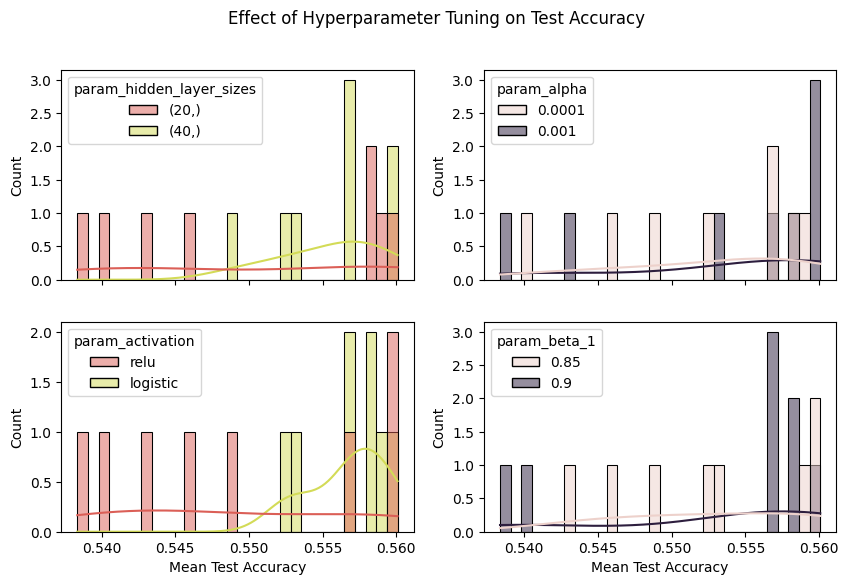

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
plt.suptitle('Effect of Hyperparameter Tuning on MLP Test Accuracy')
sns.histplot(x='mean_test_score', data=mlp_cv_results_df, bins=30, hue='param_hidden_layer_sizes', kde=True, ax=ax1) 
plt.xlabel('Mean Test Accuracy')
sns.histplot(x='mean_test_score', data=mlp_cv_results_df, bins=30, hue='param_alpha', kde=True, ax=ax2) 
sns.histplot(x='mean_test_score', data=mlp_cv_results_df, bins=30, hue='param_activation', kde=True, ax=ax3) 
sns.histplot(x='mean_test_score', data=mlp_cv_results_df, bins=30, hue='param_beta_1', kde=True, ax=ax4) 
ax3.set_xlabel('Mean Test Accuracy')
plt.savefig(os.path.join(plots_dir, 'mlp_tuning_hist.png'))

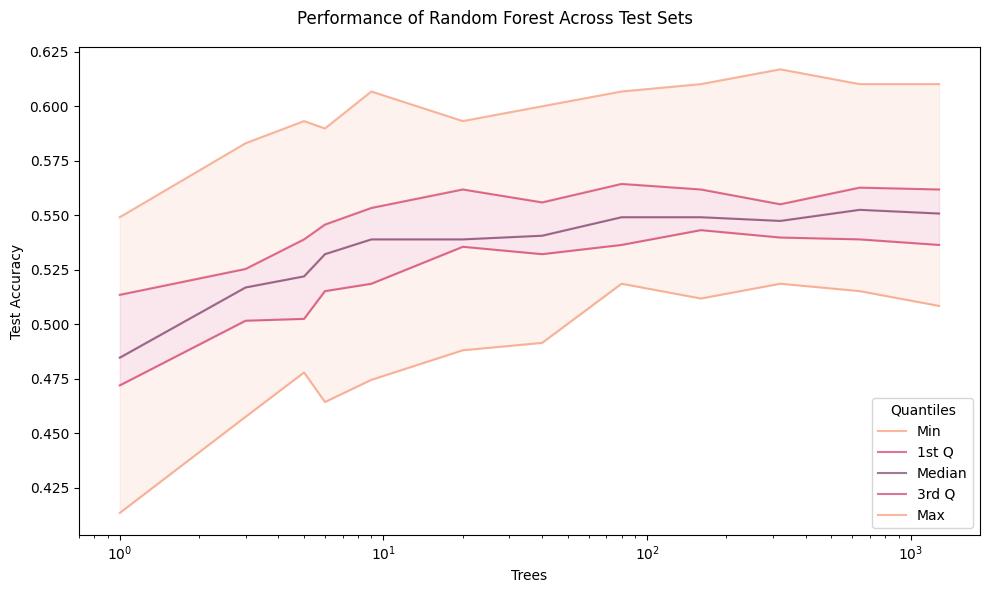

In [ ]:
rf_df = utils.classifier_test(feature_df, target, RandomForestClassifier, {'max_depth': 10},
                         rf_estimators, 'n_estimators', False, 'Trees', rf_runs, True, start_seed
                         )

utils.plot_classifier_results('Random Forest', rf_df, 'Trees', True, plots_dir, False)
model_accuracy['random_forest'] = round(float(rf_df.groupby('Trees')['Test Accuracy'].mean().max()), 3)

In [25]:
rf_classifier = RandomForestClassifier(random_state=start_seed)

rf_params = {
    'n_estimators': [20, 100, 200],
    'max_depth': [3, 7, 12, 20],
    'min_samples_split': [2, 25, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss']
}
rf_grid_search = GridSearchCV(rf_classifier, rf_params, cv=rf_tuning_runs, verbose=1)
rf_grid_search.fit(feature_df, target)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=82),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 7, 12, 20],
                         'min_samples_split': [2, 25, 100, 200],
                         'n_estimators': [20, 100, 200]},
             verbose=1)

In [26]:
raw_rf_cv_results_df = pd.DataFrame(rf_grid_search.cv_results_)
rf_cv_results_df = raw_rf_cv_results_df.drop(columns=['std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'std_test_score', 'mean_fit_time'] + [col for col in raw_rf_cv_results_df.columns if 'split' in col and 'min' not in col])
# rf_cv_results_df.sort_values('rank_test_score')

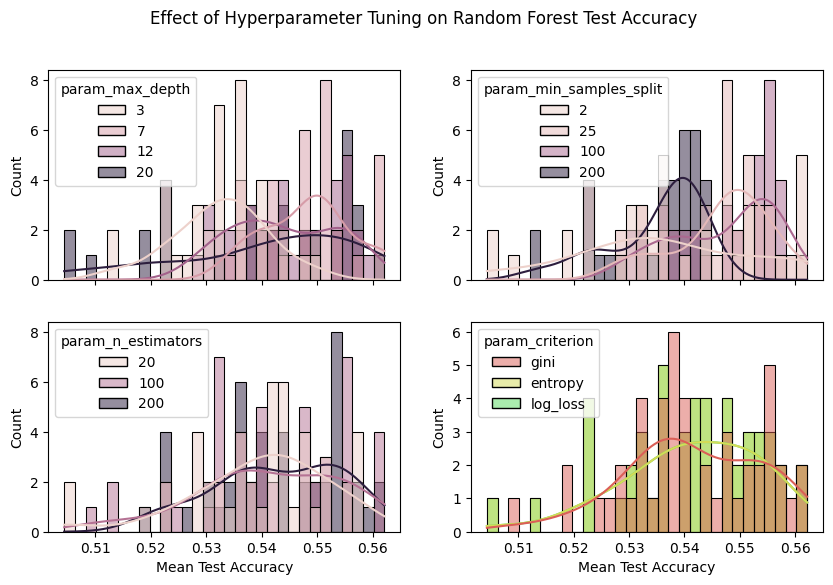

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
plt.suptitle('Effect of Hyperparameter Tuning on Random Forest Test Accuracy')
sns.histplot(x='mean_test_score', data=rf_cv_results_df, bins=30, hue='param_max_depth', kde=True, ax=ax1) 
plt.xlabel('Mean Test Accuracy')
sns.histplot(x='mean_test_score', data=rf_cv_results_df, bins=30, hue='param_min_samples_split', kde=True, ax=ax2) 
sns.histplot(x='mean_test_score', data=rf_cv_results_df, bins=30, hue='param_n_estimators', kde=True, ax=ax3) 
sns.histplot(x='mean_test_score', data=rf_cv_results_df, bins=30, hue='param_criterion', kde=True, ax=ax4) 
ax3.set_xlabel('Mean Test Accuracy')
plt.savefig(os.path.join(plots_dir, 'hidden_layer_tuning_hist.png'))